In [1]:
# Valentin L'HOMEL
# 922110009
#########################

# Code initialization

## Import section

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy.io
from PIL import Image

import math

## File loading

In [3]:
matrixEx1 = np.matrix(scipy.io.loadmat('./Exercise_1_data/adjacencyMatrix.mat')['A'])

brainGraph1 = np.matrix(scipy.io.loadmat('./Exercise_2_data/brainGraph1.mat')['W'])
brainGraph2 = np.matrix(scipy.io.loadmat('./Exercise_2_data/brainGraph2.mat')['W'])

image1 = Image.open('./Exercise_3_data/image1.jpg')
image1 = np.asarray(image1.resize((int(image1.width / 8), int(image1.height / 8))))
image2 = Image.open('./Exercise_3_data/image2.jpg')
image2 = np.asarray(image2.resize((int(image2.width / 8), int(image2.height / 8))))

## Useful functions

In [4]:
def remapMatrixLog(matrix):
    N = len(matrix)
    return np.matrix([
        [
            math.inf if matrix[i,j] == 0 else
            -math.log(matrix[i,j])
        for j in range(N)]
    for i in range(N)])

In [5]:
def remapMatrix0_1(matrix):
    N = len(matrix)
    return np.matrix([
        [
            1 - matrix[i,j]
        for j in range(N)]
    for i in range(N)])

In [6]:
def thresholdMatrix(matrix, thresholdValue):
    N = len(matrix)
    return np.matrix([
        [
            matrix[i,j] if matrix[i,j] >= thresholdValue else
            0
        for j in range(N)]
    for i in range(N)])

# 1. Bellman-Ford shortest path algorithm

### 1.1 *Explain the key steps of Bellman-Ford algorithm*

1. Initialize datas as follow:
   * Set each node distance as infinity ($d_i = \infin$)
   * Set initial node distance as zero ($d_0 = 0$)
   * Get the list of all existing edges $E_{ij}$, following an arbitrary order. Get both edges $E_{ij}$ and $E_{ji}$ if they exist.

2. For each existing edges $E_{ij}$, compare the current distance of the second node with the distance of the first node plus the weight of the edge ($d_j\ |\ d_i + w_{E_{ij}}$)
   * If the sum is lower than the current distance, override it ($d_j > d_i + w_{E_{ij}} \implies d_j = d_i + w_{E_{ij}}$)

3. After iterating through each edges, reiterates again the second step.
   * Stop after reiterating $n-1$ times, where $n$ is the number of nodes.
   * If no changes have been performed during an iteration, there is no need to reiterate again.

### 1.2. *Write a* BellmanFordAlgo *function*

*Your* BellmanFordAlgo *function should takes as input the adjacency matrix $A$ of a weighted graph $G$ and a starting node, and should return an array of elements, composed of a node of $G$, the shortest distance from the starting node to the the element's node, and the next-to-last node from the shortest path.*

In [7]:
def BellmanFordAlgo(matrix, startingNode):
    # Retrieving the list of edges
    edges = []
    for node1, row in enumerate(matrix.A):
        for node2, weight in enumerate(row):
            if weight != 0:
                edges.append((node1,node2))
    
    # Creating the initial table
    table = [{
        'node': i,
        'shortest distance': 0 if i == startingNode else math.inf,
        'previous node': None
     } for i in range(len(matrix))]

    # Completing the table of distance
    for iter in range(len(matrix) - 1):
        didChange = False
        for (node1,node2) in edges:
            if (table[node1]['shortest distance'] + matrix[node1,node2] < table[node2]['shortest distance']):
                table[node2]['shortest distance'] = table[node1]['shortest distance'] + matrix[node1,node2]
                table[node2]['previous node'] = node1
                didChange = True
        if not didChange: break
    return table


### 1.3. *Run your* BellmanFordAlgo *function on the provided data*

*The input adjacency matrix $A$ is available under the* Exercise_1_data *folder.*

&emsp;**Note**: The matrix has been loaded during the code initialization under the variable `matrixEx1`.

In [8]:
print(np.array(BellmanFordAlgo(matrixEx1, 0)))

[{'node': 0, 'shortest distance': 0, 'previous node': None}
 {'node': 1, 'shortest distance': 1, 'previous node': 0}
 {'node': 2, 'shortest distance': 2, 'previous node': 0}
 {'node': 3, 'shortest distance': 5, 'previous node': 1}
 {'node': 4, 'shortest distance': 8, 'previous node': 3}
 {'node': 5, 'shortest distance': 5, 'previous node': 2}]


# 2. Global efficiency, diffusion efficiency and graph morphospace

### 2.1. *Write a function* globalEfficiency

*Your* globalEfficiency *function should takes as input a graph adjacency matrix $A$, and outputs the global efficiency value $E_{glob}$. The global efficiency is defined as the inverse of the harmonic mean, i.e. the mean value of all inverse of shortest length.*

\begin{equation}
  E_{glob} = \frac{\sum{1/l_{ij}}}{n(n-1)}, i \neq j
\end{equation}

In [9]:
def globalEfficiency(matrix):
    N = len(matrix)
    # Sum of all length(i,j)
    sumdist = sum([
        sum([
            0 if lij['node'] == i else
            0 if lij['shortest distance'] == math.inf else
            1 / lij['shortest distance']
        for lij in BellmanFordAlgo(matrix, i)])
    for i in range(N)])
    return sumdist / (N * (N - 1))

### 2.2. *Write a function* diffusionEfficiency

*Your* diffusionEfficiency *function should takes as input a graph adjacency matrix $A$, and outputs the diffusion efficiency value $E_{diff}$. The diffusion efficiency is defined as the mean value of all inverse of mean first-passage time.*

$$ E_{diff} = \frac{\sum{1/t_{ij}}}{n(n-1)}, i \neq j $$
$$ t_{ij} = \sum_k^n{[(\mathbf{1}-U_j)^{-1}]_{ki}} $$

In [10]:
def diffusionEfficiency(matrix):
    def matrixNullifyRow(matrix, row):
        matrix.A[row] = [0 * len(matrix.A[row])]
        return matrix

    N = len(matrix)
    I = np.identity(N)
    U = matrix * np.linalg.inv(np.diag([sum(row) for row in matrix.A]))
    # (1-Uj)^-1 for all j
    tmps = [np.linalg.inv(I - matrixNullifyRow(U.copy(), j)) for j in range(N)]
    t = np.matrix([
        [
            sum([tmps[j][k,i] for k in range(N)])
        for j in range(N)]
    for i in range(N)])
    
    sumt = sum([
        sum([
            0 if i == j else
            1 / t[i,j]
        for j in range(N)])
    for i in range(N)])
    return sumt / (N * (N - 1))

### 2.3. *Plot the global efficiency of the provided brains graphs*

*The x-axis of your plot should represents the threshold value $\alpha \in [0 : 0.1 : 0.9]$, while your y-axis should represents the global efficiency $E_{glob}$ of the two given brains' graph adjacency matrices. Both plots should be on the same figure, with different colors.*

*Both brain graphs are available under the* Exercise_2_data *folder.*

<div><p style="position: relative; right: -20px"><b>Note</b>: The two matrices have been loaded during the code initialization under the variables <code>brainGraph1</code> and <code>brainGraph2</code>, as have been the functions <code>remapMatrix*</code> and <code>thresholdMatrix</code>.</p></div>

In [11]:
Eglob1 = [globalEfficiency(remapMatrix0_1(thresholdMatrix(brainGraph1, i/10))) for i in range(10)]
Eglob2 = [globalEfficiency(remapMatrix0_1(thresholdMatrix(brainGraph2, i/10))) for i in range(10)]

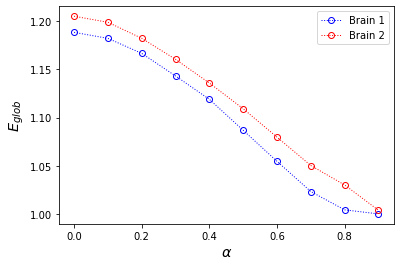

In [12]:
plt.plot([i/10 for i in range(len(Eglob1))], Eglob1, 'ob:', label='Brain 1', linewidth=1, fillstyle='none')
plt.plot([i/10 for i in range(len(Eglob2))], Eglob2, 'or:', label='Brain 2', linewidth=1, fillstyle='none')
plt.legend()
plt.xlabel(r'$\alpha$', size='x-large')
plt.ylabel(r'$E_{glob}$', size='x-large')
plt.show()

### 2.4. *Plot the diffusion efficiency, as previously*

*The x-axis of your plot should represents the threshold value $\alpha \in [0 : 0.1 : 0.9]$, while your y-axis should represents the diffusion efficiency $E_{diff}$ of the two given brains' graph adjacency matrices. Both plots should be on the same figure, with different colors.*

In [13]:
Ediff1 = [diffusionEfficiency(remapMatrix0_1(thresholdMatrix(brainGraph1, i/10))) for i in range(10)]
Ediff2 = [diffusionEfficiency(remapMatrix0_1(thresholdMatrix(brainGraph2, i/10))) for i in range(10)]

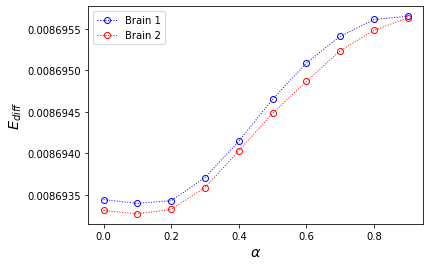

In [14]:
plt.plot([i/10 for i in range(len(Ediff1))], Ediff1, 'ob:', label='Brain 1', linewidth=1, fillstyle='none')
plt.plot([i/10 for i in range(len(Ediff2))], Ediff2, 'or:', label='Brain 2', linewidth=1, fillstyle='none')
plt.legend()
plt.xlabel(r'$\alpha$', size='x-large')
plt.ylabel(r'$E_{diff}$', size='x-large')
plt.show()

### 2.5. *What conclusions can you derive from previous plots? Compare diffusion and global efficiencies within a single graph and across both graphs*

From the previous plts, we can observe that both graphs have a quite high global efficiency, which decrease when removing lowly weighted edges. This implies that the shortest paths are bounded to these lowly weighted edges.

We can also observe a reverse phenomenon with the diffusion efficiency. Both graphs have a low diffusion efficiency, which slightly decrease when removing about 20% of the low edges, but increase after that. This implies that the lowest weighted edges are almost never part of trails, and there are slightly less alternative trails with a higher number of steps when removing lowly weighted edges.

When comparing graphs, we can observe that the brain 2 has an overall higher global efficiency but lower diffusion efficiency than the brain 1. However, they seems to be almost similar when keeping only the 10% highest edges of both graphs.

### 2.6. *Plot a morphospace for the set of thresholded brain graphs*

*The x-axis should represents the diffusion efficiency $E_{diff}$, and the y-axis the global efficiency $E_{glob}$. The morphospace should contains the two provided brain graphs, displayed with different colors, thresholded between 0 and 0.9 with a step of 0.1.*

<div><p style="position: relative; right: -20px"><b>Note</b>: On the following morphospace, the transparency of points is proportional to their threshold value. The more transparent, the more thresholded.</p></div>

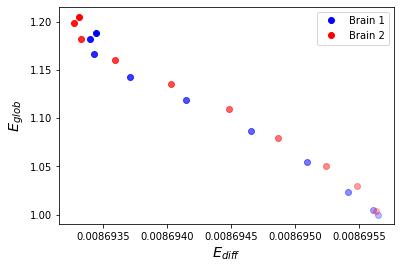

In [15]:
for i in range(len(Ediff1)):
    plt.plot([Ediff1[i]], [Eglob1[i]], 'ob', alpha=1-0.08*i, label='Brain 1' if i == 0 else None)
for i in range(len(Ediff1)):
    plt.plot([Ediff2[i]], [Eglob2[i]], 'or', alpha=1-0.08*i, label='Brain 2' if i == 0 else None)
plt.legend()
plt.xlabel(r'$E_{diff}$', size='x-large')
plt.ylabel(r'$E_{glob}$', size='x-large')
plt.show()

### 2.7. *Discuss the information flow efficiency for both brain graphs based on the morphospace*

**Note**: It is very likely that the diffusion efficiency $E_{diff}$ is incorrect on the previous graphs.

According to the previous morphospace, it appears that both brains are efficient for transmitting informations to a specific target, thanks to their high global efficiency, but are not designed to diffuse the informations. 

It is very likely that those brains observe a modular design, with several highly intraconnected clusters being lowly interconnected to each others. This is supported by the very low diffusion efficiency, meaning that informations is very unlikely to reach another module when randomly diffuse, as well as the high global efficiency, meaning there is a quite direct trail that can link every two nodes.

Considering both efficiency do not vary much when removing less important connections, it seems appropriate to suppose the interconnection between the clusters have a high weight, while intraconnection are less weighted. Indeed, the fact that global efficiency stay high when thresholded imply that the between clusters connection are still present. Moreover, the increase of diffusion efficiency imply that there are there is more probability to reach another module, and so, there are less intraconnection.

# 3. Graph self-diffusion for image segmentation

### 3.1. *Write a function called* selfDiffuse

*Your* selfDiffuse *function should takes as input a weighted graph adjacency matrix $W$ and outputs the diffused matrix $W^*$. The optimal number of diffusion iterations $t^*$ should be automatically define.*

$$D = \begin{cases} \sum_k{W_{ik}} & \text{if } i = j \\ 0 & \text{otherwise} \end{cases}$$
$$P = D^{-1}W$$
$$W_t = W_{t-1}P+I = (I-P^t)(I-P)^{-1} + WP^t$$
$$W^* = W_{t^*}D^{-1}$$
$$t^* = \left\lceil\frac{\ln{\frac{\epsilon}{(n-Trace(P))||W-WP-I||}}}{\ln{(\lambda_2-C)}}\right\rceil$$

In [16]:
def optimalDiffusionIteration(W, epsilon=1, C=0.05):
    N = len(W)
    I = np.identity(N)
    P = np.linalg.inv(np.diag(W.sum(axis=1).A1)) * W
    lambdas, _ = np.linalg.eig(P)
    return math.ceil(np.log(epsilon / ((N - np.trace(P)) * np.linalg.norm(W-W*P-I))) / np.log(sorted(lambdas, reverse=True)[1] - C))

def _selfDiffuse(W, t):
    I = np.identity(len(W))
    Dinv = np.linalg.inv(np.diag(W.sum(axis=1).A1))
    P = Dinv * W
    #Pt = P**t
    #return ((I-Pt) * np.linalg.inv(I-P) + W*Pt) * Dinv

    Wt = W.copy()
    for _ in range(t):
        Wt = Wt*P + I

    return Wt*Dinv

def selfDiffuse(W):
    return _selfDiffuse(W, optimalDiffusionIteration(W))

### 3.2. *Display the original and diffused matrices for the provided brain graphs*

*The diffused matrix should be obtained using your* selfDiffuse *function.*

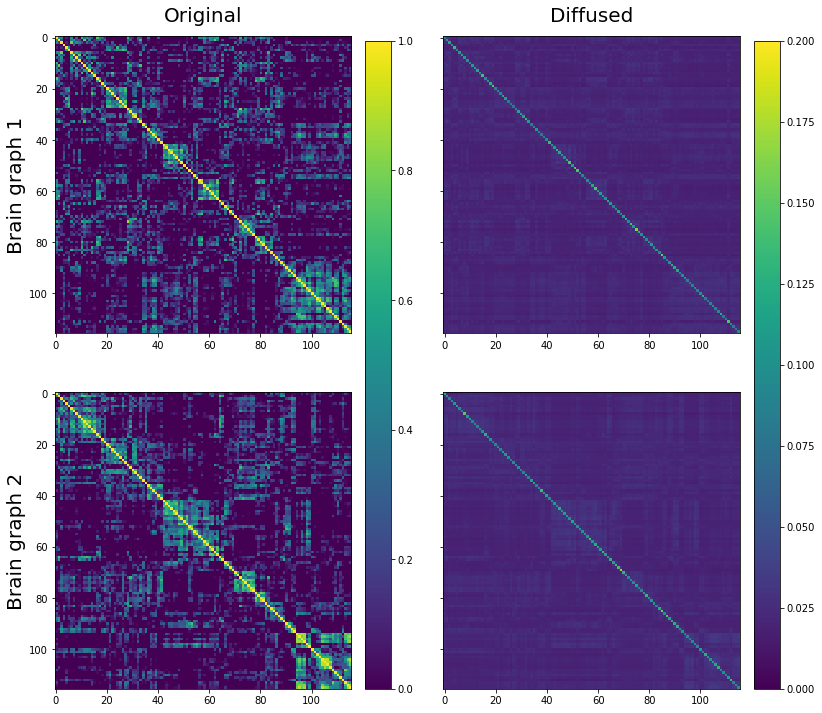

In [17]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(12, 12), sharey=True)
plt.subplots_adjust(right=0.95)

plt.sca(ax0)
plt.imshow(brainGraph1, interpolation='nearest', vmin=0, vmax=1)
plt.sca(ax2)
plt.imshow(brainGraph2, interpolation='nearest', vmin=0, vmax=1)
cax = plt.axes([0.5, 0.125, 0.03, 0.75])
plt.colorbar(cax=cax)

plt.sca(ax1)
plt.imshow(selfDiffuse(brainGraph1), interpolation='nearest', vmin=0, vmax=0.2)
plt.sca(ax3)
plt.imshow(selfDiffuse(brainGraph2), interpolation='nearest', vmin=0, vmax=0.2)
cax = plt.axes([0.95, 0.125, 0.03, 0.75])
plt.colorbar(cax=cax)

plt.text(0.5, 1.05, "Original", {'fontsize': 20}, horizontalalignment='center', transform=ax0.transAxes)
plt.text(0.5, 1.05, "Diffused", {'fontsize': 20}, horizontalalignment='center', transform=ax1.transAxes)
plt.text(-0.16, 0.5, "Brain graph 1", {'fontsize': 20}, rotation=90, verticalalignment='center', transform=ax0.transAxes)
plt.text(-0.16, 0.5, "Brain graph 2", {'fontsize': 20}, rotation=90, verticalalignment='center', transform=ax2.transAxes)
plt.show()

### 3.3. *For the two provided images, display the original image and its corresponding segmentation map, using the given [Normalized Cut Python code](https://github.com/marktao99/python/blob/master/CVP/samples/ncut.py)*

*Both images are available under the* Exercise_2_data *folder.*

<div><p style="position: relative; right: -15px"><b>Note</b>: The two images have been loaded during the code initialization under the variables <code>image1</code> and <code>image2</code>. Furthermore, they have been downscaled by a factor of 8 to reduce resources consumption.</p></div>

&emsp;**Note 2**: It is possible to edit the following variable to change the number of color on the segmentated maps.

In [18]:
NUMBER_OF_COLOR = 10

#### External python code

In [19]:
import scipy.cluster.vq

def cluster(S,k,ndim):
    """ Spectral clustering from a similarity matrix."""
    
    # check for symmetry
    if np.sum(abs(S-S.T)) > 1e-10:
        print('not symmetric')
    
    # create Laplacian matrix
    rowsum = np.sum(abs(S),axis=0)
    D = np.diag(1 / np.sqrt(rowsum + 1e-6))
    L = np.dot(D,np.dot(S,D))
    
    # compute eigenvectors of L
    U,sigma,V = np.linalg.svd(L,full_matrices=False)
    
    # create feature vector from ndim first eigenvectors
    # by stacking eigenvectors as columns
    features = np.array(V[:ndim]).T

    # k-means
    features = scipy.cluster.vq.whiten(features)
    centroids,distortion = scipy.cluster.vq.kmeans(features,k)
    code,distance = scipy.cluster.vq.vq(features,centroids)
        
    return code,V

def ncut_graph_matrix(im,sigma_d=1e2,sigma_g=1e-2):
    """ Create matrix for normalized cut. The parameters are 
        the weights for pixel distance and pixel similarity. """
    
    m,n = im.shape[:2] 
    N = m*n
    
    # normalize and create feature vector of RGB or grayscale
    vim = im / im.max()
    if len(im.shape)==3:
        vim = vim.reshape((-1,3))
    else:
        vim = vim.flatten()
    
    # x,y coordinates for distance computation
    xx,yy = np.meshgrid(range(n),range(m))
    x,y = xx.flatten(),yy.flatten()
    
    # create matrix with edge weights
    W = np.zeros((N,N),'f')
    for i in range(N):
        for j in range(i,N):
            d = (x[i]-x[j])**2 + (y[i]-y[j])**2 
            W[i,j] = W[j,i] = np.exp(-1.0*sum((vim[i]-vim[j])**2)/sigma_g) * np.exp(-d/sigma_d)
    
    return W

#### Actual code

In [20]:
similarityMatrix1 = ncut_graph_matrix(image1)
similarityMatrix2 = ncut_graph_matrix(image2)

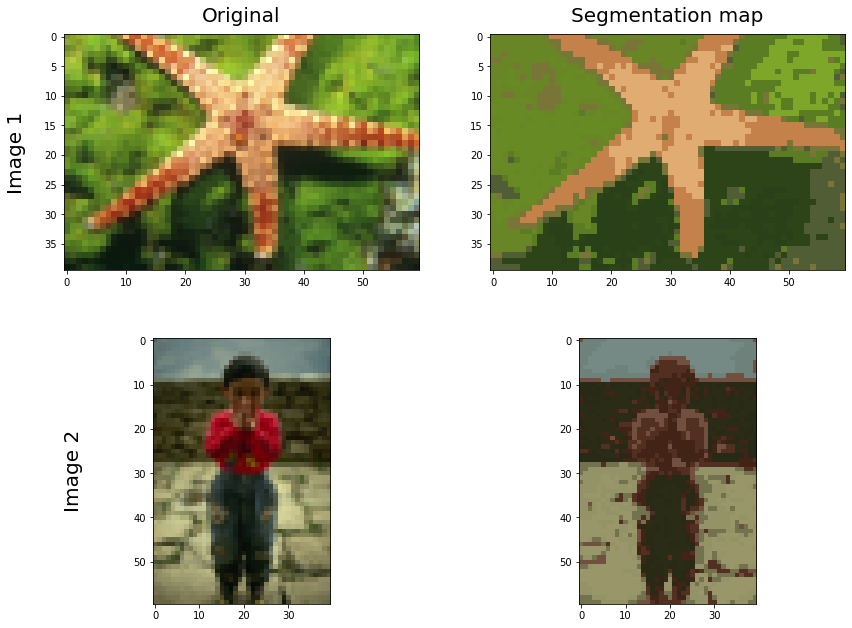

In [21]:
def drawSegmentedMap(W, baseImage):
    # Get the cluster each pixel belong to
    clust = cluster(W, NUMBER_OF_COLOR, baseImage.shape[2])[0].reshape(baseImage.shape[:2])
    # Associate a color to each cluster by taking the average of their color
    colors = [
        [
            np.average(colorComponent) / 256
         for colorComponent in zip(*baseImage[clust == color])] # image1[clust == color] return the pixels belonging to cluster $color$
     for color in range(NUMBER_OF_COLOR)]
    plt.imshow(clust, matplotlib.colors.ListedColormap(colors))


fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(14, 14))
plt.subplots_adjust(bottom=0.3)

plt.sca(ax0)
plt.imshow(image1)
plt.sca(ax2)
plt.imshow(image2)

plt.sca(ax1)
drawSegmentedMap(similarityMatrix1, image1)
plt.sca(ax3)
drawSegmentedMap(similarityMatrix2, image2)

plt.text(0.5, 1.05, "Original", {'fontsize': 20}, horizontalalignment='center', transform=ax0.transAxes)
plt.text(0.5, 1.05, "Segmentation map", {'fontsize': 20}, horizontalalignment='center', transform=ax1.transAxes)
plt.text(-0.16, 0.5, "Image 1", {'fontsize': 20}, rotation=90, verticalalignment='center', transform=ax0.transAxes)
plt.text(-0.5, 0.5, "Image 2", {'fontsize': 20}, rotation=90, verticalalignment='center', transform=ax2.transAxes)
plt.show()

### 3.4. *Reiterate the previous exercice while diffusing the similarity matrix*

*The similarity matrix $W$ should be diffused using your* selfDiffuse *function. Each images should be displayed with the following diffusion iterations $t$: $\{1,\ \frac{1}{2}t^*,\ t^*,\ \frac{3}{2}t^*,\ 2t^*\}$, where $t^*$ is the optimal number of diffusion iterations.*

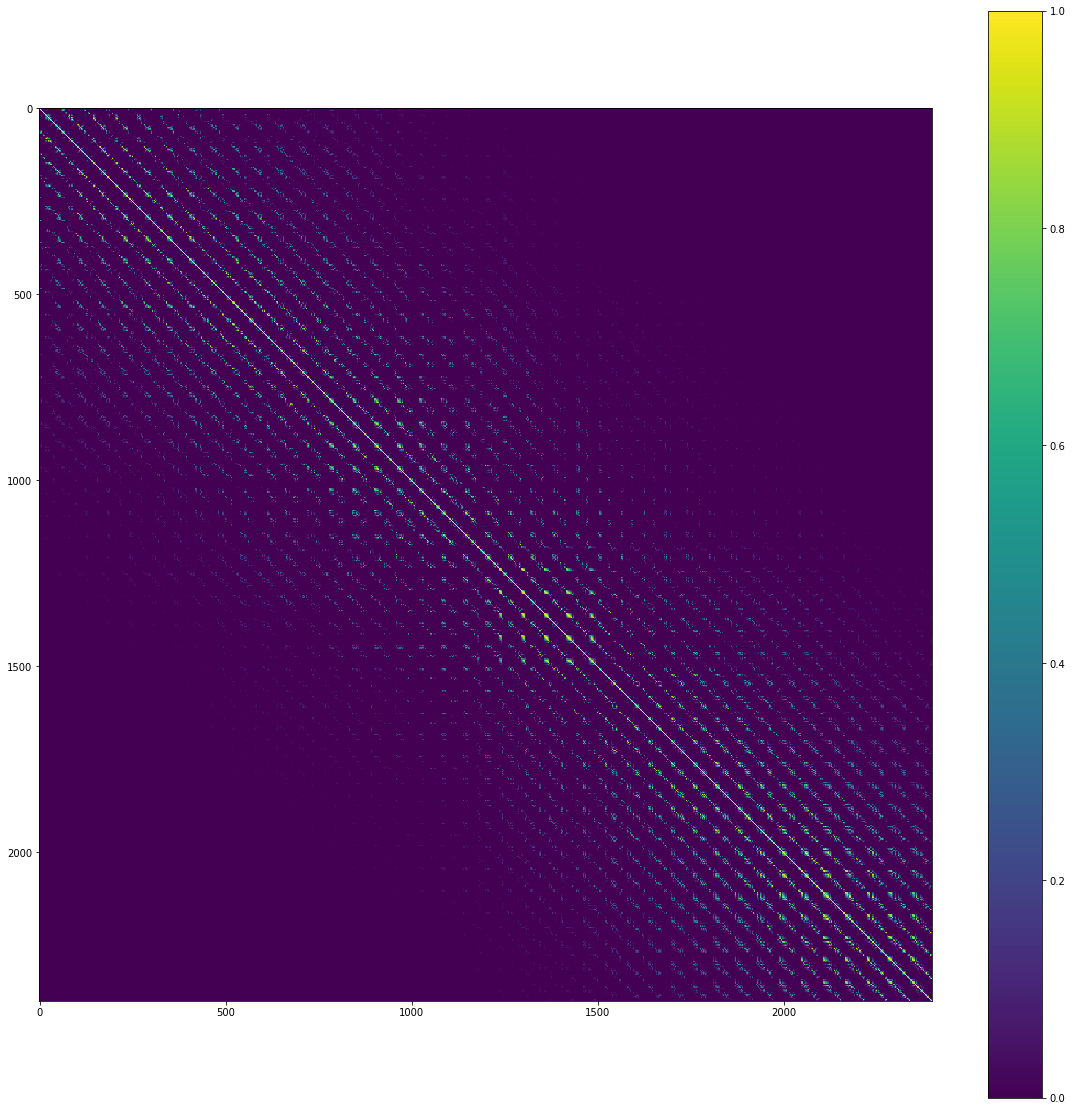

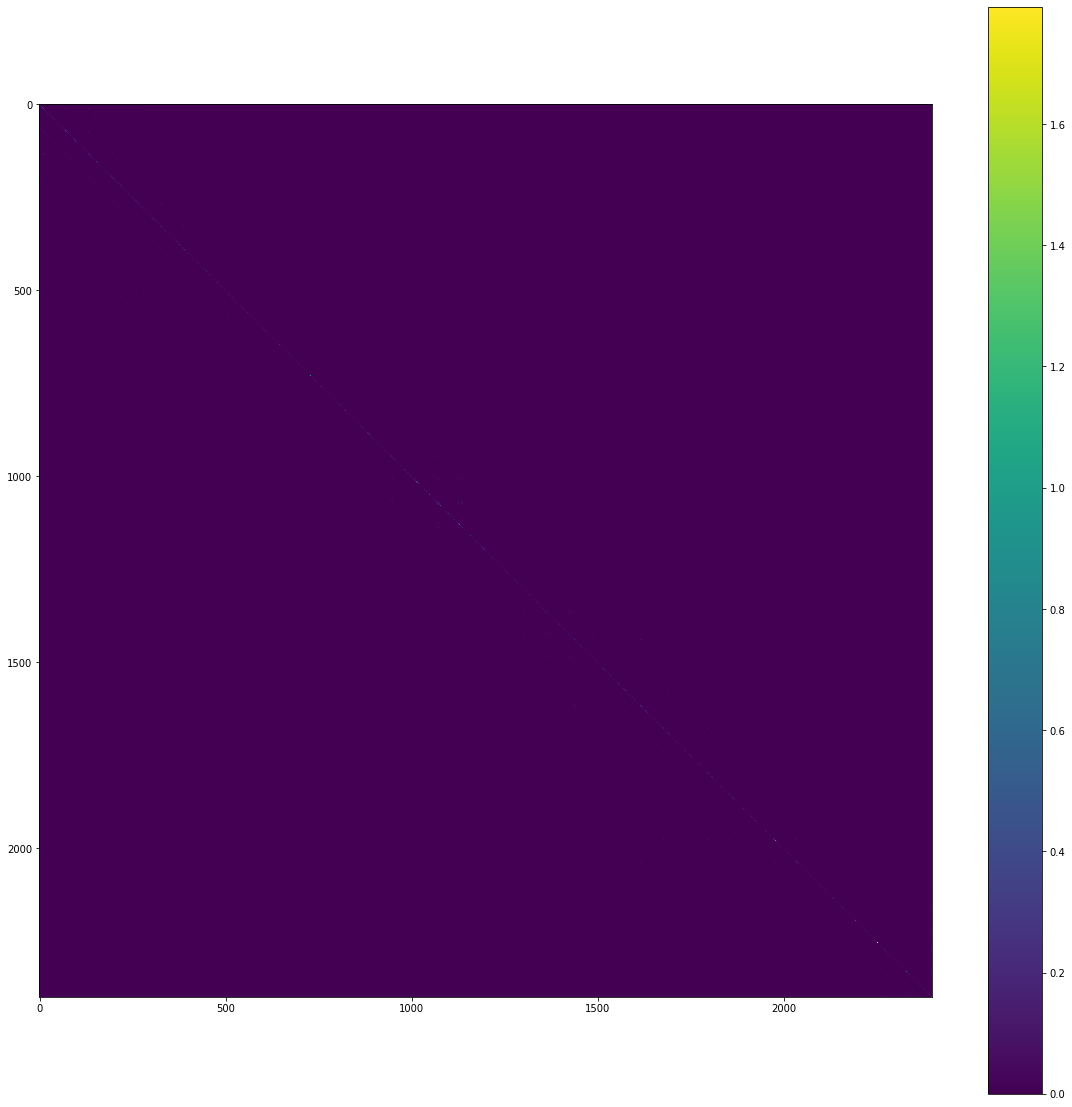

In [22]:
#fig, ((ax11, ax12, ax13, ax14, ax15, ax16), (ax21, ax22, ax23, ax24, ax25, ax26)) = plt.subplots(2, 6, figsize=(12, 12))

#plt.sca(ax11)
#plt.imshow(image1)
#plt.sca(ax21)
#plt.imshow(image2)
#plt.show()

plt.figure(figsize=(20,20))
plt.imshow(np.asmatrix(similarityMatrix1), interpolation='nearest')
plt.colorbar()
plt.show()

plt.figure(figsize=(20,20))
plt.imshow(_selfDiffuse(np.asmatrix(similarityMatrix1), 1), interpolation='nearest')
plt.colorbar()
plt.show()